# Lab 4 - What Factors Matter for the Van Dantzig Model?
**Due**: Monday, 2/20 by 1:00pm.

Make sure you include your name and ID below for submission. <br>
**Name**:  <br>
**ID**:

## Contents

In [35]:
# load project environment
import Pkg # load the Pkg package manager
Pkg.activate(@__DIR__) # activate the environment in the directory of the script file
Pkg.instantiate() # make sure all of the needed packages are installed with correct versions

  Activating project at `~/Teaching/BEE6940/labs/lab03`


---

## Introduction

Following the [North Sea of 1953](https://en.wikipedia.org/wiki/North_Sea_flood_of_1953), the Dutch government developed its Delta project, aimed at protecting the Netherlands from infrequent but catastrophic flooding in the future. The mathematician [David Van Dantzig](https://en.wikipedia.org/wiki/David_van_Dantzig) was asked to develop and solve a cost-benefit framework for levee heights, the result of which is presented in Van Dantzig (1956). 

### The Van Dantzig (1956) Model

The model decomposes total costs into up-front investment costs for construction and expected discounted future damages. Unlike Van Dantzig, we will make the simplifying assumption that there is no initial levee.

#### Investment Costs

The model begins by considering construction costs, which are treated as linear (under the assumption that the heightening will be relatively small). Letting $H$ be the height of the constructed levee (in $m$), $I_0$ the initial investment cost (in Dutch guilders, for consistency with Van Dantzig's analysis), and $k$ the marginal cost of construction (in guilders/m), the investment cost is
$$I(H) = I_0 + kH.$$

#### Expected Discount Damages

Van Dantzig assumes that there is a certain rate of relative sea-level rise $\eta$ (including subsidence and absolute sea-level rise) which reduces the effectiveness of the levee over time. This makes the "effective height" after $t$ years
$$H_e(t) = H - \eta t.$$

A further assumption is that exceedances are exponentially distributed:
$$p(H, t) = p_0 e^{-\alpha H_e(t)}.$$

Van Dantzig also makes the assumption that, upon a flooding event, the polder is completely flooded and the entire value-at-risk $V$ within the polder is lost, but that all repairs are complete prior to the next year, so the value is restored. This means that the expected damages in any given future year is
$$L(H, t) = V p(H, t) = Vp_0 e^{-\alpha H_e(t)}.$$

Finally, applying a discount rate $\delta$, the average net-present value of expected damages (or the expected annual discounted damages) over the $T$-year lifetime of the levee is
$$L(H) = \frac{1}{T} \sum_{t=1}^T V p(H, t) \frac{1}{(1+\delta)^t} = \frac{1}{T} \sum_{t=1}^T Vp_0 e^{-\alpha H_e(t)} \frac{1}{(1+\delta)^t}.$$

#### Total Costs

The total costs, used for the cost-benefit analysis, are then the sum $$C(H) = I(H) + L(H).$$

### Model Implementation

Let's implement the Van Dantzig (1956) model in Julia. We'll use some default parameters, some of which are taken from Van Dantzig (1956) and some of which are modified.

In [79]:
## create the Van Dantzig (1956) model

# set default parameters
p₀ = 0.0038 # baseline flood frequency
α = 2.6 # exponential flood frequency rate
V = 2e12 # value of assets within polder in guilders/m
I₀ = 0 # fixed cost of dike construction in guilders
k = 4.2e7 # marginal cost of dike construction in guilders/m
η = 0.01 # annual rate of relative sea-level rise (m/yr)
δ = 0.02 # discount rate (%/yr)
T = 75 # number of years for problem solution

function construct_cost(H, I₀, k)
    return I₀ + k * H
end

function expected_damages(H, V, p₀, α, η, δ, T)
    yrs = collect(1:T) 
    Hₑ = (H .- (η .* yrs)) # compute effective heights over lifespan of levee
    return (V * p₀) * mean(exp.(-α .* Hₑ) ./ (1 + δ).^yrs)
end

function total_cost(H, I₀, k, V, p₀, α, η, δ, T)
    return construct_cost(H, I₀, k) + expected_damages(H, V, p₀, α, η, δ, T)
end



total_cost (generic function with 1 method)

Let's plot the total costs across a variety of levee heights to see how they change.

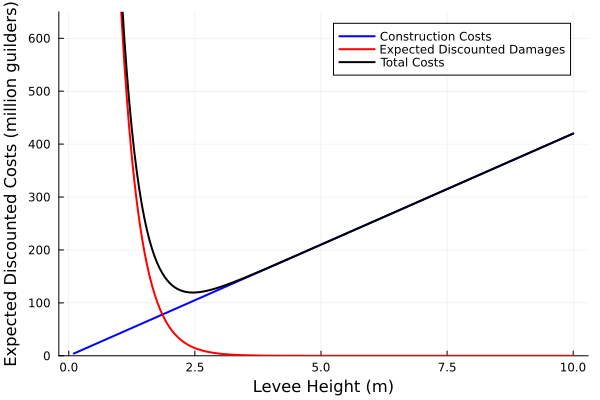

In [80]:
using Plots
using StatsBase

cc(H) = construct_cost(H, I₀, k)
dam(H) = expected_damages(H, V, p₀, α, η, δ, T)
van_danzig_cost(H) = total_cost(H, I₀, k, V, p₀, α, η, δ, T)

levee_heights = 0.1:0.05:10 # heights to consider
levee_costs = van_danzig_cost.(levee_heights)
const_costs = cc.(levee_heights)
disc_damages = dam.(levee_heights)
plot(levee_heights, const_costs ./ 1e6, color=:blue, linewidth=2, label="Construction Costs", legend=:topright, xlabel="Levee Height (m)", ylabel="Expected Discounted Costs (million guilders)", ylims=(0, 650))
plot!(levee_heights, disc_damages ./ 1e6, color=:red, linewidth=2, label="Expected Discounted Damages")
plot!(levee_heights, levee_costs ./ 1e6, color=:black, linewidth=2, label="Total Costs")

From this plot, it looks like the height which minimizes the total discounting cost is somewhere around 2.5m. Next, let's optimize to find this value.

In [81]:
using Optim

# optimize over the interval [0.1, 10] and return the minimizing height
res = optimize(van_danzig_cost, 0.1, 10) 
levee_optim = round(Optim.minimizer(res), digits=2)

2.46

Our goal in this notebook is to understand the key drivers of outcomes in the Van Dantzig (1956) model through a sensitivity analysis. Sensitivity analyses quantify the degree to which changes in inputs affect output value(s). Sensitivity analysis methods (which we will hopefully discuss more later) can be broadly categorized along two dimensions. 
1. Global vs. Local: 
    - A "local" sensitivity analysis looks at the impact of perturbing a parameter from a fixed "base" value. 
    - A "global" sensitivity analysis aggregates the impact of parameter values across the input domain.
2. One-at-a-time (OAT) vs. All-At-A-Time: 
    - OAT sensitivity analyses vary each parameter individually while holding the other parameters fixed. This can be computationally simpler, but may miss interactions between parameters (*e.g.* co-varying two parameters results in more drastic changes than varying each parameter individually).
    - All-At-A-Time analyses vary parameters in combination, which is more computationally intensive but allows for the identification of cross-parameter interactions.

## Exercises
Complete the following exercises. Convert your completed notebook to a PDF and submit it to the Gradescope Assignment "Lab 4".

Remember to evaluate all of your code cells, in order (using a Run All command). This will make sure all output is visible and that the code cells were evaluated in the correct order.

### Exercise 1: Global One-At-A-Time (OAT) Sensitivity Analysis

Let's conduct a "global" one-at-a-time sensitivity analysis using the [Method of Morris](https://en.wikipedia.org/wiki/Morris_method). A global sensitivity analysis method quantifies how the variability of the output is affected by the variability of the input across the entire domain, rather than around a fixed baseline point.

The Method of Morris calculates local sensitivity, or "elementary effects," by calculating a local derivative at each parameter at various points along its range, and then computes a global sensitivity index by averaging these effects:
$$S_i = \frac{1}{r} \sum_{j=1}^r \frac{f(x^j_1, x^j_2, \ldots, x^j_i + \Delta_i, \ldots, x^j_n) - f(x^j_1, x^j_2, \ldots, x^j_i, \ldots, x^j_n)}{\Delta_i}.$$

$S_i$ corresponds to the average rate of change of the function value $f$ with respect to input $x_i$, which is one interpretation of sensitivity.

In Julia, we can use the `GlobalSensitivity.jl` package for the Method of Morris, using [`gsa(f, Morris, v)`](https://docs.sciml.ai/GlobalSensitivity/stable/methods/morris/), where `v` is a vector of tuples corresponding to bounds for each variable. This output can be queried to get the mean index and its variance:

```julia
s = gsa(f, Morris, v) # compute Morris indices 
abs(s.means) # query means, and take absolute value as a measure of sensitivity
s.variances # compute variances
```

A high variance, reflecting that the local sensitivity changes depending on the value, suggests that the function response is highly nonlinear or that there are interaction effects between parameters.

#### Exercise 1.1 (10 points)

Use the Method of Morris over the following intervals to identify the sensitivity of expected discounted damages for a levee height of 2.5m over 75 years to each parameter:

| Parameter | Lower Bound | Upper Bound |
|:---------:|------------:|------------:|
| $p_0$ | $0.003$ | $0.005$ |
| $\alpha$ | $2$ | $3$ |
| $V$ | $1.5 \times 10^{12}$ | $2.5 \times 10^{12}$ |
| $\eta$ | $0.006$ | $0.01$ |
| $\delta$ | $0.01$ | $0.04$ |

#### Exercise 1.2 (10 points)

Plot the means and variances of the elementary effects for each parameter (I suggest using bar plots). You can use LaTeX strings as labels with the `LaTeXStrings` package: after `using LaTeXStrings`, `L"$\alpha$"` will print $\alpha$. 

Rank the parameters with respect to the sensitivity indices. Is there evidence of any nonlinearities or parameter interactions?

### Exercise 2: Sensitivity of Optimal Levee Height

In Exercise 1, we looked at the sensitivity of performance of a fixed levee height as we varied the input parameters. Another important question under uncertainty is what uncertainties might drive different decision-making.

#### Exercise 2.1 (10 points)

Write a wrapper function (intended for use with `gsa`) which returns the optimal levee height given the varying input parameters.

#### Exercise 2.2 (10 points)

Use the Method of Morris, with the same parameter ranges as in Exercise 1 and the additional parameters below, to compute the sensitivities of the optimal height to variability in the parameter values.

| Parameter | Lower Bound | Upper Bound |
|:---------:|------------:|------------:|
| $I_0$ | $0$ | $1 \times 10^7$ |
| $k$ | $3.8 \times 10^7$ | $4.5 \times 10^7$ |

#### Exercise 2.3 (10 points)

Plot the means and variances of the sensitivity indices. What is different from the results in Exercise 1.2? Does this make sense?

## References

Give credit to any consulted references here, whether they were your classmates, online resources, or anything else.